<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/2021SmartGrids/L_04_MPC_for_DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model predictive control for Demand Side Managment
In this lesson we will go through a practical introduction to model predictive control (MPC) for the control of energy systems and its role in demand side management applications.

The thermal model of the building can be expressed with an equivalent thermal circuit RC, in which the insulation is expressed in the form of thermal resistance and the thermal inertia (ratio between the heat exchanged between the body and the environment and the variation of temperature that follows) is expressed in the form of form of capacity.

A thermal circuit can be expressed exactly as an electrical circuit by applying the following analogies electric by applying the following analogies:

| Quantity    | Electrical |  Thermal|
| ----------- | -----------    | ----------- | 
| Potential   | $U$ [$V$]      | $T$ [$K$]   |
| Flux        | $I$ [$A$]      | $P$ [$W$]   |
| Resistance  | $R$ [$\Omega$] | $R_{th}$ [$K/W$]|
| Capacity    | $C$ [$F$]      | $C_{th}$ [J/K]|

The following figure illustrates one state RC equivalent of a building in which the heat sources are a heating system, solar inputs and the presence of people. Usually, a multi-state system identification is performed. The number of identifiable states greatly depends on the number of temperature and power sensors available and on the signal to noise ratio of the available measurements. Despite its simplicity, the one state RC is well suited to illustrate the methodology of controlling a dynamic system for DSM applications.
The external temperature is modeled with a voltage source, while the injected thermal powers with a current source.

<center><img src="https://github.com/nepslor/teaching/raw/main/2021SmartGrids/figs/RC_circuit.png" width="600">


In [184]:
%%capture
!pip install cvxpy
!pip install statsmodels==0.12.2
import cvxpy as cvx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
data = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/2021SmartGrids/data/L04_inputs.csv',  sep=',', index_col=0)
data.index = pd.DatetimeIndex(data.index, freq='H')

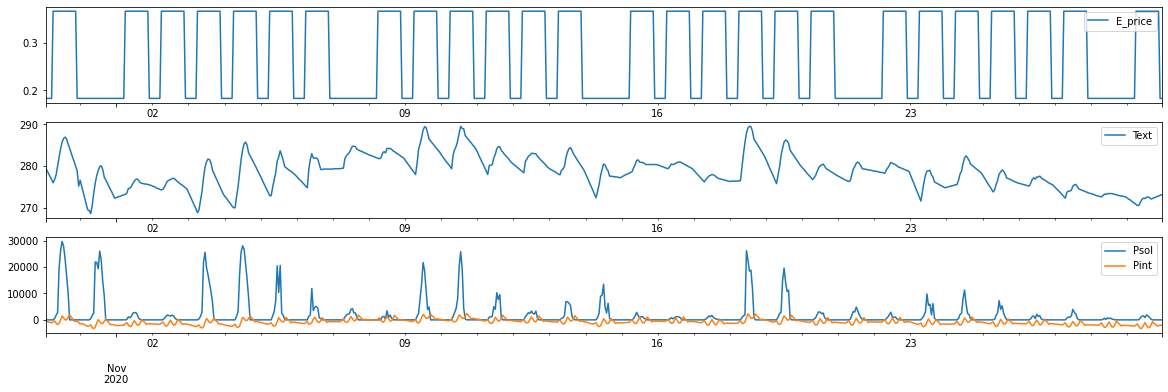

In [185]:
def multiplot(data, *args):
  fig, ax = plt.subplots(len(args), 1, figsize=(20, 2*len(args)))
  for i, p in enumerate(args):
    data[p].plot(ax=ax[i])

data_tr = data.loc[data.index<'2020-10-30']
data_te = data.loc[(data.index<'2020-11-30') & (data.index>'2020-10-30')]
multiplot(data_te, ['E_price'], ['Text'], ['Psol', 'Pint'])


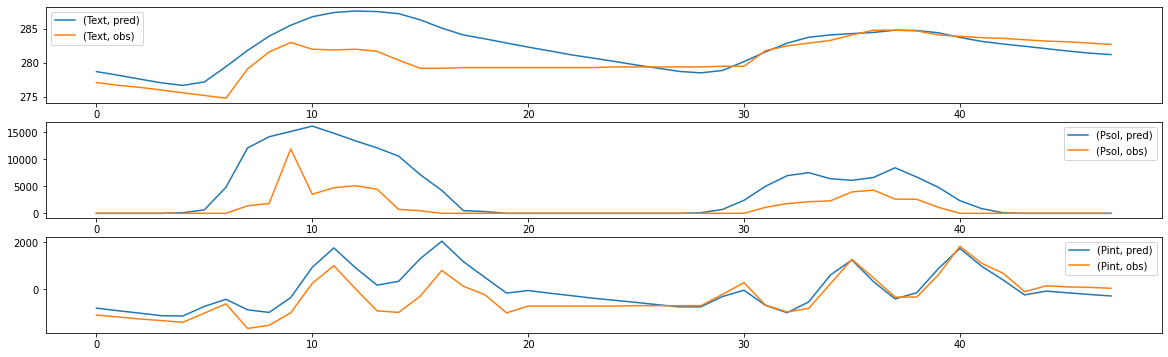

In [192]:
from sklearn.neighbors import KNeighborsRegressor
from itertools import product
  
def add_lags(data, lags, names='all'):
  "adds lagged version of the signal with a given name to the data in the \
  DataFrame. Positive lags: shift forward (future), negative lags: shift\
  backward (past)."
  lagged_signal = pd.concat([data.copy()[names].shift(-l) for l in lags], axis=1)
  lagged_signal.columns = ['{}_lag_{}'.format(p[1], p[0]) for p in 
                           product(lags, names)]
  lagged_dat = pd.concat([data, lagged_signal], axis=1)
  return lagged_dat.loc[~np.any(lagged_dat.isna(), axis=1)]

def tr_te_split(data, split_ratio=0.75):
  "divides data into training and test sets "
  n_tr = int(len(data)*split_ratio)
  return data.iloc[:n_tr, :], data.iloc[n_tr:, :]

def fit_forecasters(input_tr, input_te, names):
  forecasters, forecasts, perfect_forecasts, test_obs = {}, {}, {}, {}
  for target in names:
    future_steps = np.arange(1,48)
    past_steps = -np.hstack([np.arange(1,25),np.arange(1,7)*24, np.arange(168-24,169)])
    data_tr = add_lags(input_tr, (future_steps).tolist() + (past_steps).tolist(), names=names)
    data_te = add_lags(input_te, (future_steps).tolist() + (past_steps).tolist(), names=names)

    x_tr, x_te = data_tr[[n for n in data_tr.columns if '-' in n]], data_te[[n for n in data_te.columns if '-' in n]]
    y_tr, y_te = data_tr[[n for n in data_tr.columns if target in n and '-' not in n]], data_te[[n for n in data_te.columns if target in n  and '-' not in n]]

    # normalize data
    tr_mean, te_mean = x_tr.mean(), x_te.mean()
    tr_std, te_std = x_tr.std(), x_te.std()
    x_tr = (x_tr-tr_mean)/tr_std
    x_te = (x_te-te_mean)/te_std

    forecasters[target] = KNeighborsRegressor(weights='distance').fit(x_tr, y_tr.values)
    forecasts[target] = forecasters[target].predict(x_te) 
    perfect_forecasts[target] = y_te.values 
    test_obs[target] = y_te 
  return forecasters, forecasts, perfect_forecasts, test_obs

targets=['Text', 'Psol', 'Pint']
forecasters, forecasts, perfect_forecasts, test_obs = fit_forecasters(data_tr, data_te, targets)
plot_names = list(product(targets, ['pred', 'obs']))
forecast_sample = pd.DataFrame(np.vstack([(forecasts[k][0, :], test_obs[k].values[0, :]) 
for k in targets]).T, columns=plot_names)
multiplot(forecast_sample, plot_names[:2], plot_names[2:4], plot_names[4:])


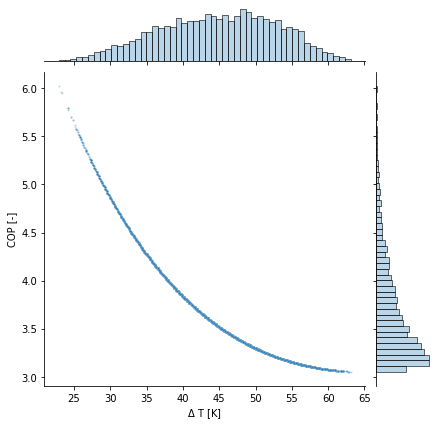

In [188]:
ts = 3600              # Sampling time [s]
h = 48                 # control horizon [time steps]

N = len(data_te)-h     # maximum available timestep
P_hp_nom = 4.088       # nominal power of the heat pump [W]
T_dist = 273.15 + 55   # temperature of water in the heating system [K]

# Let's define an approximate function of the HP coefficient of performance as 
# a function of temeprature difference between heating system's water 
# temperature and ambient temperature
cop = lambda t_dist, t_ext: 13.39*np.exp(-0.047*(t_dist-t_ext))+1.109*np.exp(0.012*(t_dist-t_ext))
COP = cop(T_dist, data['Text'])

# plot the COP
spl = sb.jointplot(x=T_dist-data['Text'], y=COP.values, s=4,alpha=0.3, marginal_kws=dict(bins=50, alpha=0.3))
spl.ax_joint.set_xlabel('$\Delta$ T [K]')
spl.ax_joint.set_ylabel('COP [-]');

In [189]:
C = 4.83e7            # C - heat capacity [kJ/K]
U = 652.8             # External conductivity [kW/K]

Ac = np.atleast_2d(np.array(-U/C))
Bc = np.atleast_2d(np.array([U/C, 1/C]))

# Exact discretization
Ad = np.exp(ts*Ac)        
Bd = np.linalg.inv(Ac)@(Ad - 1)@Bc

[[0.95250883]]
[[4.74911690e-02 7.27499525e-05]]


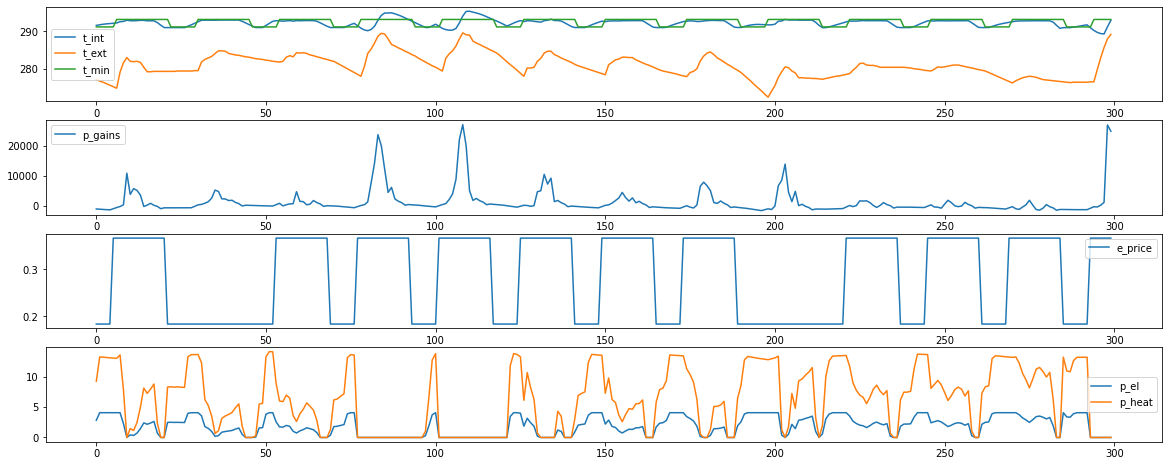

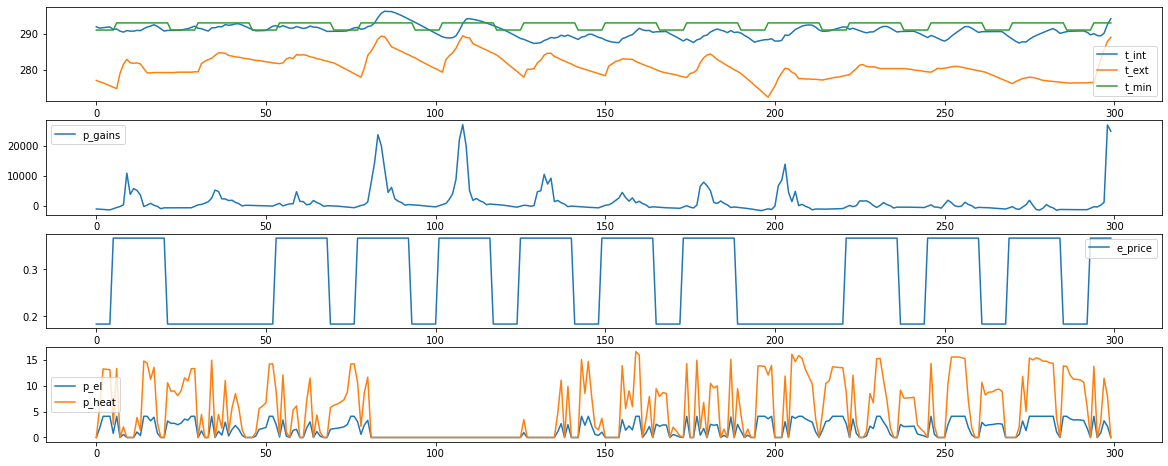

In [193]:

k_eco = 10  # relative importance of the economic objective
 
# Setpoint temperature of the heating system: daytime=20°C, nightime=20°C
t_int_min = (np.kron(np.ones(int((N+h+1)/24)), np.hstack([18]*6 + [20]*16 + [18]*2))+273.15)[:data_te.shape[0]]

# variables - the optimization problem will search for the best values of these
# quantities

t_int = cvx.Variable((h+1, 1), name='internal temperature')
p_heat_hp = cvx.Variable((h, 1), name='heating power HP')
p_el_hp = cvx.Variable((h, 1), name='electric power HP')


# parameters - these can be set at each instance of the problems
p_gains = cvx.Parameter((h, 1), name='forecasted internal gains')
t_ext = cvx.Parameter((h, 1), name='forecasted external temperature')
cop_hp = cvx.Parameter((h, 1), name='forecasted COP of the HP')
e_price = cvx.Parameter((h, 1), name='electricity price')
t_int_min_h = cvx.Parameter((h, 1), name='minimum internal temperature')
t_init = cvx.Parameter(1)

# initial internal house temperature
constraints = [t_int[0] == t_init]  

# heat dynamics of the building
constraints.append(t_int[1:] == Ad @ t_int[0:-1] + t_ext*Bd[0,0] + (p_gains + p_heat_hp*1e3)* Bd[0,1])

# heating power constraints of the heat pump
constraints.append(0 <= p_heat_hp) 
constraints.append(p_heat_hp == cvx.multiply(cop_hp, p_el_hp))

# electric power constraints of the heat pump
constraints.append(0 <= p_el_hp) 
constraints.append(p_el_hp <= P_hp_nom)
#constraints.append(t_int_min_h <= t_int[0:-1] + slack)

# set objective function to minimize
objective = cvx.sum((t_int_min_h-t_int[0:-1])**2) + k_eco*cvx.sum(cvx.multiply(e_price, p_el_hp))
problem = cvx.Problem(cvx.Minimize(objective), constraints=constraints)

# initial temperature
t_int_obs = np.atleast_1d(t_int_min[0]+0.5)

mpc_forecats = perfect_forecasts
n_steps = 300
history = pd.DataFrame(columns=['t_int', 't_ext', 't_min', 'p_gains', 'e_price', 'p_el', 'p_heat'], index=np.arange(n_steps))
for i in range(n_steps):
  p_gains.value = np.vstack([mpc_forecats[k][i, :] for k in ['Pint', 'Psol']]).T.sum(axis=1, keepdims=True)
  t_ext.value = mpc_forecats['Text'][[i], :].T
  cop_hp.value = cop(T_dist, t_ext.value)
  e_price.value = data_te['E_price'].iloc[i:i+h].values.reshape(-1,1)
  t_int_min_h.value = t_int_min[i:i+h].reshape(-1,1)
  t_init.value = np.atleast_1d(t_int_obs)

  problem.solve()

  # obtain realized temperature 
  t_ext_obs = test_obs['Text'].iloc[i, 0]
  p_gains_obs = (test_obs['Psol'].iloc[i, 0] + test_obs['Pint'].iloc[i, 0])
  
  t_int_obs = Ad @ t_int_obs + t_ext_obs * Bd[0,0] + (p_gains_obs + p_heat_hp.value[0]*1e3)*Bd[0,1]
  history.iloc[i, :] = np.hstack([t_int_obs, t_ext_obs, t_int_min_h.value[0], p_gains_obs, e_price.value[0], p_el_hp.value[0], p_heat_hp.value[0]])

multiplot(history, ['t_int', 't_ext', 't_min'], ['p_gains'], ['e_price'], ['p_el', 'p_heat'])

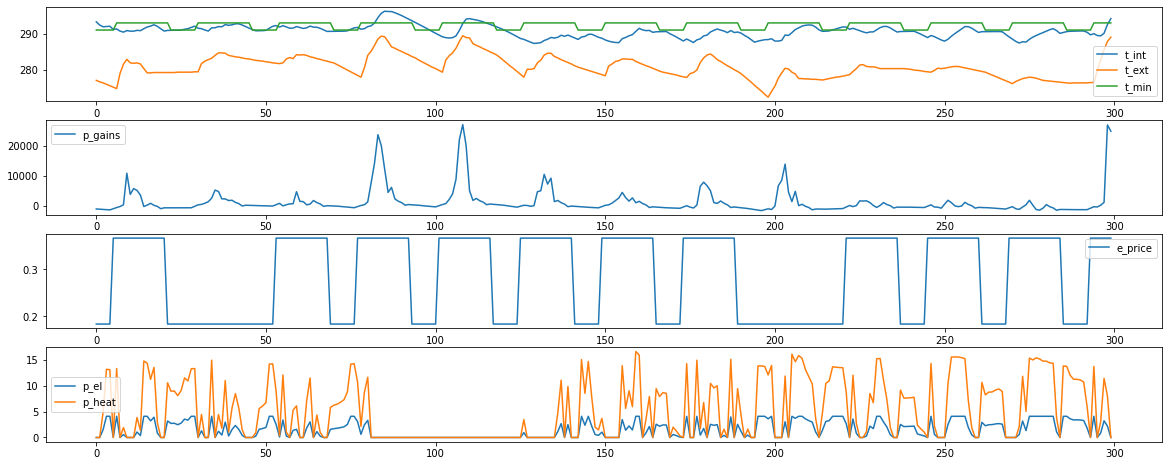

In [194]:
mpc_forecats = forecasts
n_steps = 300
history = pd.DataFrame(columns=['t_int', 't_ext', 't_min', 'p_gains', 'e_price', 'p_el', 'p_heat'], index=np.arange(n_steps))
for i in range(n_steps):
  p_gains.value = np.vstack([mpc_forecats[k][i, :] for k in ['Pint', 'Psol']]).T.sum(axis=1, keepdims=True)
  t_ext.value = mpc_forecats['Text'][[i], :].T
  cop_hp.value = cop(T_dist, t_ext.value)
  e_price.value = data_te['E_price'].iloc[i:i+h].values.reshape(-1,1)
  t_int_min_h.value = t_int_min[i:i+h].reshape(-1,1)
  t_init.value = np.atleast_1d(t_int_obs)

  problem.solve()

  # obtain realized temperature 
  t_ext_obs = test_obs['Text'].iloc[i, 0]
  p_gains_obs = (test_obs['Psol'].iloc[i, 0] + test_obs['Pint'].iloc[i, 0])
  
  t_int_obs = Ad @ t_int_obs + t_ext_obs * Bd[0,0] + (p_gains_obs + p_heat_hp.value[0]*1e3)*Bd[0,1]
  history.iloc[i, :] = np.hstack([t_int_obs, t_ext_obs, t_int_min_h.value[0], p_gains_obs, e_price.value[0], p_el_hp.value[0], p_heat_hp.value[0]])

multiplot(history, ['t_int', 't_ext', 't_min'], ['p_gains'], ['e_price'], ['p_el', 'p_heat'])